In [40]:
import pandas as pd # Pour le dataframe
import numpy as np # Pour la normalisation et calculs de moyenne
import matplotlib.pyplot as plt # Pour la visualisation

from PIL import Image

import librosa # Pour l'extraction des features et la lecture des fichiers wav
import librosa.display # Pour récupérer les spectrogrammes des audio
import librosa.feature

import os # C'est ce qui va nous permettre d'itérer sur les fichiers de l'environnement de travail

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV # Split de dataset et optimisation des hyperparamètres
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.ensemble import GradientBoostingClassifier # XGBoost
from sklearn.neighbors import KNeighborsClassifier # k-NN
from sklearn.svm import SVC # SVM
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report # Métriques pour la mesure de performances
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf # Pour le reseau de neurones simple et pour le CNN
from tensorflow.keras.models import load_model

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam
from keras.utils import to_categorical

from xgboost import XGBClassifier
from pprint import pprint

In [8]:
#Voici la liste des genres musicaux représentés dans la notre base de données, on en compte 10.
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

#On commence par initialiser le dictionnaire avec les clés qui sont les noms des genres.
#On met autant de listes vides qu'il n'y a de genres.

In [9]:
# Créer un dictionnaire vide pour stocker les données audio pour chaque genre
audio_files = {}

# Itérer sur la liste des genres
for g in genres:
    # Créer une liste vide pour stocker les données audio pour le genre actuel
    audio_files[g] = []

In [10]:
# Itérer sur les fichiers audio dans le répertoire pour le genre actuel
for audio in os.listdir(f'./Data/genres_original/{g}'):
    # Charger les données audio en utilisant librosa et les ajouter à la liste pour le genre actuel
    audio_data = librosa.load(f'./Data/genres_original/{g}/{audio}')[0]
    audio_files[g].append(audio_data)

In [11]:
print(audio) #Une chaîne de caractère est passée et non un échantillon audio...

rock.00099.wav


In [12]:
print(audio_data)

[-0.02111816 -0.03451538 -0.03536987 ...  0.00134277  0.00250244
 -0.00186157]


Maintenant que nous avons présentés toutes les features que l'on a considéré, construisons un pipeline pour créer une base d'apprentissage.\
Toutes ces features sont facilement calculables avec la librairie Python Librosa.\
_Ce pipeline nous servira aussi pour essayer nos modèles sur des fichiers musicaux externes (YouTube par exemple)._

In [13]:
def audio_pipeline(audio):
  
  features = []

  # Calcul du ZCR

  zcr = librosa.zero_crossings(audio)
  features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

  spectral_centroids = librosa.feature.spectral_centroid(y=audio)[0]
  features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point

  rolloff = librosa.feature.spectral_rolloff(y=audio)
  features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCC

  mfcc = librosa.feature.mfcc(y=audio)

  for x in mfcc:
    features.append(np.mean(x))

  return features

On écrit les noms des features dans les colonnes d'un dataframe :

In [14]:
column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']

In [15]:
df = pd.DataFrame(columns = column_names)

In [16]:
df.head()

,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label


In [17]:
i = 0
for g in genres:
  for music in audio_files[g]:
    df.loc[i] = audio_pipeline(music)+[g]
    i+=1

In [18]:
df.to_csv('./csv_result/result.csv', index = False)

In [19]:
df = pd.read_csv("./csv_result/result.csv")

In [20]:
df.head()

,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,59810,1996.329188,4227.868737,-116.626260,109.25263,-23.163752,40.679480,-11.888836,23.152943,-15.409277,...,8.497991,-11.577596,2.197697,-6.180506,1.989980,-7.955889,2.083384,-2.392914,-1.541793,rock
1,36427,1529.290808,3271.448122,-111.252850,134.15211,-24.658050,41.542343,-3.075081,28.475187,-10.599551,...,9.940146,-4.680241,3.621828,-5.555471,3.361646,-4.956296,-1.477911,0.089316,-5.348198,rock
2,50935,1875.180216,3929.493150,-120.445526,117.58980,-27.635338,42.838066,-6.757944,21.642138,-12.103040,...,13.523022,-2.420074,6.712717,-3.155412,5.470172,-2.235662,1.061179,-1.654424,-0.035615,rock
3,28563,1421.355041,3042.701555,-156.545530,130.72420,-1.480792,36.234592,0.350913,31.955034,-0.621873,...,11.537828,-3.214253,5.058525,-1.785062,3.542804,-2.444864,-0.733025,-1.424127,0.644289,rock
4,27231,1345.841383,2939.157324,-127.970420,134.44084,1.020510,54.439240,-0.454471,35.814583,-10.856743,...,11.041861,-8.380609,2.107747,-6.346208,0.991749,-5.323317,-0.843005,-4.661474,-4.788684,rock


In [21]:
selector = VarianceThreshold(threshold=(0.2))
selected_features = selector.fit_transform(df[['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                                              'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                                              'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                                              'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']])

df_select = pd.DataFrame(selected_features)

____

### Corrélations
Bien que les méthodes que nous allons implémenter dans ce projet gérent plutôt bien les variables corrélées, on peut afficher une matrice de corrélation pour mieux comprendre nos données.

Text(0.5, -0.15, 'Matrice de corrélation')

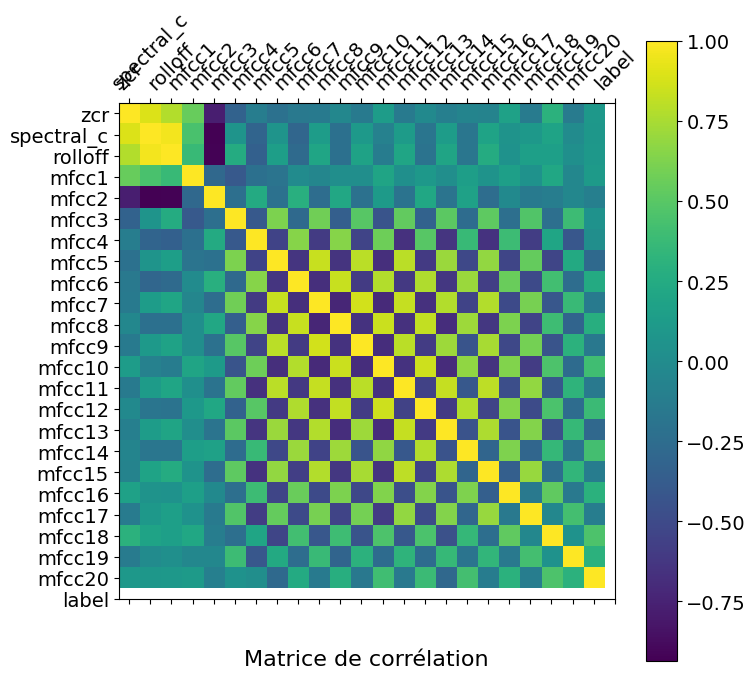

In [22]:
f = plt.figure(figsize=(8, 8))
#ax = plt.gca()
plt.matshow(df_select.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
#ax.tick_params(axis="x", bottom=True)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Matrice de corrélation', fontsize=16, y=-0.15)

___

# Introduction aux CNN
L'utilisation de réseaux de neurones convolutionnels représente la meilleure approche lorsqu'il s'agit de faire de la classification d'images.

### Création des images
Dans la cellule ci-dessous, nous assoçions tous les fichiers audio à leur spectrogramme.\
Pour cela nous devons itérer sur ces fichiers, ploter leurs spectrogrammes respectifs et sauvegarder l'image dans un dossier que nous avons créé au préalable.

Tous les spectrogrammes seront ensuite accessibles depuis le dictionnaire audio_files :

In [23]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

audio_files = {}

for g in genres:
  audio_files[g] = []

In [24]:
# Itérer sur les fichiers audio dans le répertoire pour le genre actuel
for g in genres:
  for audio in os.listdir(f'./Data/genres_original/{g}'):
    audio_files[g].append(librosa.core.load(f'./Data/genres_original/{g}/{audio}'))

### Preprocessing
On peut maintenant stocker toutes les images sous forme de matrices numpy dans un vecteur X :

Nous allons maintenant mettre en ordre nos données d'entraînement.\
On doit avoir un array que nous appelerons X (pour ne pas confondre avec le précédent X), constitué de toutes les matrices des images, ainsi qu'un array appelé y_cnn avec tous les labels.

In [25]:
mel_specs = []

for g in genres:

  for audio in audio_files[g]:

    y = audio[0]
    sr = audio[1]

    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
        
# On modifie la taille des images 128 x 660 en gardant les paramètres proposés dans l'article initial
    if spect.shape[1] != 660:
      spect.resize(128,660, refcheck=False)

    mel_specs.append(spect)
        
X = np.array(mel_specs)

On peut maintenant créer le vecteur des labels y_cnn, pour l'instant nos images sont dans l'ordre de la construction de y_cnn est triviale :

In [26]:
y_cnn = []

for i in range(len(genres)):
  y_cnn +=100*[i] # On a 100 images pour chaque genre
y_cnn = np.array(y_cnn)

Pour pouvoir utiliser y_cnn il faut la transformer en variables catégoriques par un encodage One-Hot, scikit-learn permet de le faire très facilement.

In [27]:
# On split ensuite nos données en données de test et données d'entraînements :
y_cnn = to_categorical(y_cnn)
x_cnn_train, x_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X, y_cnn)

In [28]:
# On pense à normaliser les données, c'est important pour l'analyse d'images :
x_cnn_train /= -80
x_cnn_test /= -80

In [29]:
# A présent on met en forme nos données pour l'entraînement :
x_cnn_train = x_cnn_train.reshape(x_cnn_train.shape[0], 128, 660, 1)
x_cnn_test = x_cnn_test.reshape(x_cnn_test.shape[0], 128, 660, 1)

A ce stade nous avons bien deux arrays X et y_cnn.\
X contient toutes les matrices représentants les images des spectrogrammes et y_cnn contient les labels pour chaque image.

Vérifions les tailles de x_cnn et y_cnn pour être sur qu'il n'y a pas de problème :

In [32]:
print(x_cnn_train.shape)
print(y_cnn_train.shape)

(750, 128, 660, 1)
(750, 10)


___

# Construction du CNN

In [33]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,660,1)))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(32, 
                 kernel_size=(3, 3), 
                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

Avant de lancer l'entraînement du réseau, voyons un résumé des couches que l'on a :

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 658, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 329, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 327, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 163, 64)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 163, 64)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 161, 32)       1

On compile le modèle en selectionnant la categorical crossentropy comme perte avec l'optimiseur ADAM.

In [35]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

On peut à présent commencer l'entraînement.\
Nous le faisons sur Google Colab pour pouvoir profiter d'un traitement parallèle sur GPU, ce qui représente un gain de temps considérable.

In [36]:
history = model.fit(x_cnn_train,
                    y_cnn_train,
                    epochs=25,
                    validation_data = (x_cnn_test,y_cnn_test))

Epoch 1/25
24/24 [==============================] - 23s 937ms/step - loss: 2.3373 - accuracy: 0.1147 - val_loss: 2.3029 - val_accuracy: 0.0920
Epoch 2/25
24/24 [==============================] - 23s 942ms/step - loss: 2.2992 - accuracy: 0.1080 - val_loss: 2.3031 - val_accuracy: 0.0920
Epoch 3/25
24/24 [==============================] - 24s 982ms/step - loss: 2.2898 - accuracy: 0.1160 - val_loss: 2.3019 - val_accuracy: 0.0920
Epoch 4/25
24/24 [==============================] - 22s 913ms/step - loss: 2.2811 - accuracy: 0.1093 - val_loss: 2.2933 - val_accuracy: 0.1520
Epoch 5/25
24/24 [==============================] - 22s 922ms/step - loss: 2.2254 - accuracy: 0.1827 - val_loss: 2.1963 - val_accuracy: 0.2640
Epoch 6/25
24/24 [==============================] - 22s 930ms/step - loss: 2.0930 - accuracy: 0.2547 - val_loss: 2.1172 - val_accuracy: 0.1960
Epoch 7/25
24/24 [==============================] - 22s 929ms/step - loss: 1.9353 - accuracy: 0.2907 - val_loss: 1.8601 - val_accuracy: 0.3000

On peut regader l'évolution des erreurs et de la loss au fur et à mesure des époques d'entraînements du modèle.

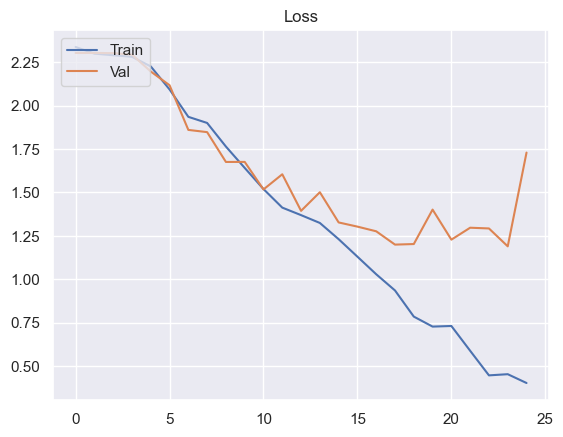

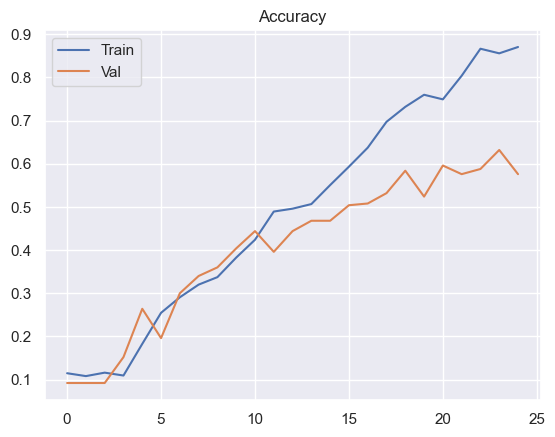

In [41]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

Bilan des performances

8/8 [==============================] - 1s 169ms/step


Text(110.44999999999997, 0.5, 'predicted label')

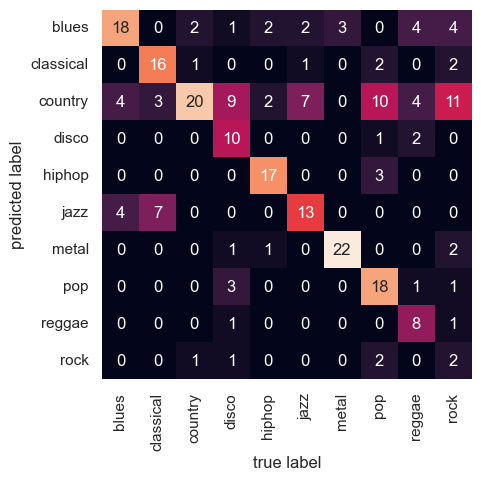

In [42]:
sns.set()
predictions = model.predict(x_cnn_test)
mat = confusion_matrix(np.argmax(y_cnn_test, 1), np.argmax(predictions, 1))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=genres, yticklabels=genres)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
# model.save('BadBoyModel.keras')

### Chargement du model

In [118]:
import keras
model = keras.models.load_model('BadBoyModel.keras')